<a href="https://colab.research.google.com/github/krishnakaushik25/handwritten_digit_recognizer-DL/blob/master/CNN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Load the data
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

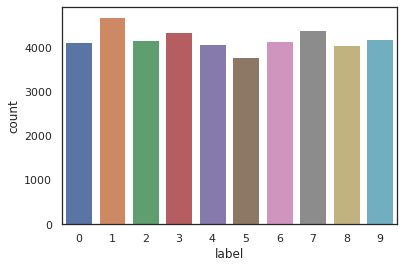

In [ ]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [ ]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

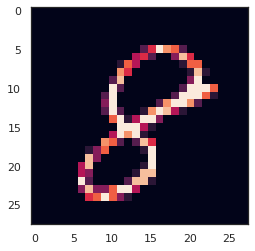

In [ ]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy",  metrics=['accuracy'])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0,
                             patience=1, verbose=1, mode='auto')

 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
history = model.fit(X_train,Y_train, validation_split=0.10, epochs=2, batch_size=86, verbose=2,
                               callbacks=[learning_rate_reduction, earlystopper])


Train on 34020 samples, validate on 3780 samples
Epoch 1/2
 - 13s - loss: 0.2532 - accuracy: 0.9187 - val_loss: 0.0563 - val_accuracy: 0.9833
Epoch 2/2
 - 7s - loss: 0.0799 - accuracy: 0.9765 - val_loss: 0.0425 - val_accuracy: 0.9862


In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:


# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, earlystopper])

Epoch 1/30
 - 16s - loss: 0.1516 - accuracy: 0.9533 - val_loss: 0.0466 - val_accuracy: 0.9862
Epoch 2/30
 - 15s - loss: 0.0951 - accuracy: 0.9716 - val_loss: 0.0389 - val_accuracy: 0.9895
Epoch 3/30
 - 16s - loss: 0.0806 - accuracy: 0.9761 - val_loss: 0.0323 - val_accuracy: 0.9912
Epoch 4/30
 - 16s - loss: 0.0681 - accuracy: 0.9798 - val_loss: 0.0303 - val_accuracy: 0.9914
Epoch 5/30
 - 16s - loss: 0.0644 - accuracy: 0.9807 - val_loss: 0.0358 - val_accuracy: 0.9888
Epoch 00005: early stopping


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


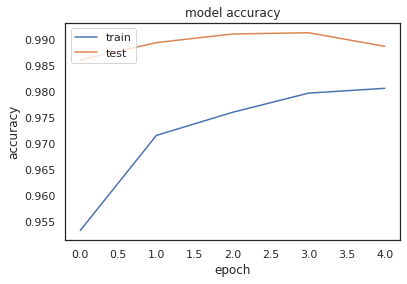

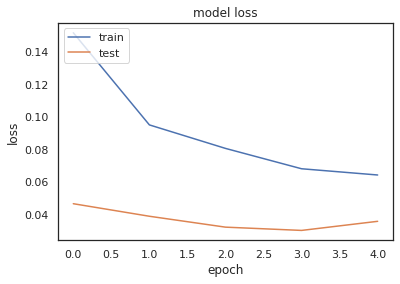

In [ ]:
# Plot the loss and accuracy curves for training and validation 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

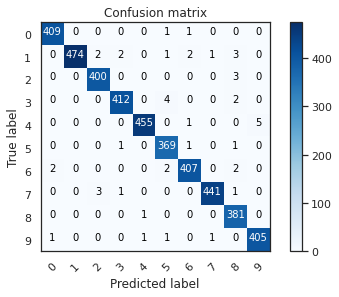

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

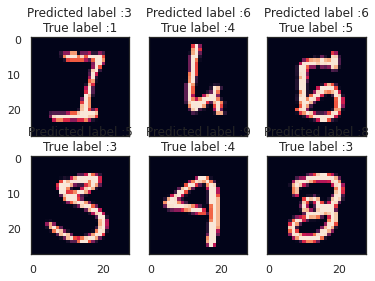

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

/content/cnn_mnist_datagen.csv in this file i got all the outputs

Using ensemble of 15 Convolutional Neural Networks!

In [ ]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [ ]:
# LOAD THE DATA
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")

In [ ]:
# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 2
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 1: Epochs=2, Train accuracy=0.98442, Validation accuracy=0.99238
CNN 2: Epochs=2, Train accuracy=0.96083, Validation accuracy=0.98452
CNN 3: Epochs=2, Train accuracy=0.95818, Validation accuracy=0.98500
CNN 4: Epochs=2, Train accuracy=0.95789, Validation accuracy=0.98905
CNN 5: Epochs=2, Train accuracy=0.95908, Validation accuracy=0.98190
CNN 6: Epochs=2, Train accuracy=0.95810, Validation accuracy=0.98429
CNN 7: Epochs=2, Train accuracy=0.96004, Validation accuracy=0.98762
CNN 8: Epochs=2, Train accuracy=0.95800, Validation accuracy=0.97333
CNN 9: Epochs=2, Train accuracy=0.96195, Validation accuracy=0.98452
CNN 10: Epochs=2, Train accuracy=0.96256, Validation accuracy=0.98119
CNN 11: Epochs=2, Train accuracy=0.95874, Validation accuracy=0.98500
CNN 12: Epochs=2, Train accuracy=0.95924, Validation accuracy=0.98762
CNN 13: Epochs=2, Train accuracy=0.95794, Validation accuracy=0.98143
CNN 14: Epochs=2, Train accuracy=0.95993, Validation accuracy=0.98333
CNN 15: Epochs=2, Train accur

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)